In [31]:
import os
import sys
import argparse
import pumpp
import shutil
import pickle
from joblib import Parallel, delayed
from pumpp.feature import Mel

sys.path.append('/home/ci411/pcen-t-varying/')
from pcen_t.utils import *
from pcen_t.pcen_pump import *

URBANSED_CLASSES = ['air_conditioner',
                    'car_horn',
                    'children_playing',
                    'dog_bark',
                    'drilling',
                    'engine_idling',
                    'gun_shot',
                    'jackhammer',
                    'siren',
                    'street_music']

In [32]:
def build_pump(sr, hop_length, n_fft, n_mels, n_t_constants=10, save_pump=None):
    pcen_t = PCEN_T(name='PCEN', sr=sr, hop_length=hop_length,\
                    n_t_constants=n_t_constants, n_mels=n_mels)
    
    p_tag = pumpp.task.StaticLabelTransformer(name='static',
                                              namespace='tag_open',
                                              labels=URBANSED_CLASSES)

    p_dtag = pumpp.task.DynamicLabelTransformer(name='dynamic',
                                                namespace='tag_open',
                                                labels=URBANSED_CLASSES,
                                                sr=sr,
                                                hop_length=hop_length)
    pump = pumpp.Pump(pcen_t, p_tag, p_dtag)
    
    if save_pump is not None:
        with open(os.path.join(save_pump, 'pump.pkl'), 'wb') as fd:
            pickle.dump(pump, fd)

    return pump

In [33]:
def build_pump_mel(sr, hop_length, n_fft, n_mels, save_pump=None):
    #leaving the name as PCEN so I don't need to change downstream code
    pcen_t = Mel(name='Mel', sr=sr, hop_length=hop_length,\
                 n_fft=n_fft, n_mels=n_mels, log=True)
    
    p_tag = pumpp.task.StaticLabelTransformer(name='static',
                                              namespace='tag_open',
                                              labels=URBANSED_CLASSES)

    p_dtag = pumpp.task.DynamicLabelTransformer(name='dynamic',
                                                namespace='tag_open',
                                                labels=URBANSED_CLASSES,
                                                sr=sr,
                                                hop_length=hop_length)
    pump = pumpp.Pump(pcen_t, p_tag, p_dtag)
    
    if save_pump is not None:
        with open(os.path.join(save_pump, 'pump.pkl'), 'wb') as fd:
            pickle.dump(pump, fd)

    return pump

In [34]:
sr = 22050
hop_length = 1024
n_fft = 1024
n_mels = 128

save_pump_pcen = '/beegfs/ci411/pcen/pumps/pcen/'
save_pump_mel = '/beegfs/ci411/pcen/pumps/mel/'

In [35]:
pcen_pump = build_pump(sr, hop_length, n_fft, n_mels, n_t_constants=10, save_pump=save_pump_pcen)
mel_pump = build_pump_mel(sr, hop_length, n_fft, n_mels,  save_pump=save_pump_mel)


In [36]:
mel_pump

In [37]:
pcen_pump['PCEN']

In [38]:
mel_pump['Mel']

In [39]:
mel_pump.ops[0].name

'Mel'

In [41]:
filename = '/beegfs/ci411/pcen/features_622/mel/URBAN-SED_reverb/test/soundscape_test_uniform402_bedroom.h5'
trim = 862

data = {}

def collect(k, v):
    if isinstance(v, h5py.Dataset):
        data[k] = v[()]

with h5py.File(filename, mode='r') as hf:
    hf.visititems(collect)

field = list(data.keys())[0]

if trim is not None:
    if len(data[field].shape)==3:
        data[field] = data[field][:,:trim,:,np.newaxis]
    else:
        data[field] = data[field][:,:trim,:,:]
    data['dynamic/tags'] = data['dynamic/tags'][:,:trim-1,:]


In [42]:
data[field].shape

(1, 223, 128, 1)

In [43]:
mel_pump['dynamic'].__dict__['fields']['dynamic/tags'].shape

(None, 10)

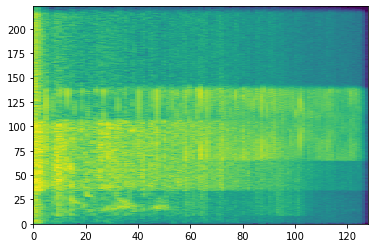

In [50]:
import matplotlib.pyplot as plt
plt.pcolormesh(np.log(data['Mel/mag'][0,:,:,0]))